### 1. install required packages:

`pip install package_name`

### 2. import packages

In [10]:
import os
import sys
import pandas as pd 
import argparse
import numpy as np 
import glob
import time 
import logging
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
import multiprocessing
from multiprocessing import  Pool
import time
import logging
from functools import partial
import random
from functools import reduce
import tqdm

### 3. load functions

In [44]:
import os
import sys
import pandas as pd 
import argparse
import numpy as np 
import glob
import time 
import logging
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
import multiprocessing
from multiprocessing import  Pool
import time
import logging
from functools import partial
import random
from functools import reduce

def plot_metagene(result, plot_group = 'alias', facet_by = None, x_col = 'pos', y_col = 'count', shade = None, title = None, sharey = False, vline = False, ylim = None) : 
    
    plot = sns.FacetGrid(result, 
                         col = facet_by, 
                         hue = plot_group, 
                         height = 4, 
                         aspect = 1.3, 
                        col_wrap = 2)

    plot.map(sns.lineplot, x_col, y_col)
        
    plot.add_legend()
    
    if shade : 
            result['m'] = result[y_col] - result[shade]
            result['M'] = result[y_col] + result[shade]
            plot.map(plt.fill_between, x_col, 'm', 'M', alpha=0.2)
            
    if vline : 
        plt.axvline(x = vline, color = 'grey', label = f'{vline} bp', alpha = 0.5)
    
    
    if title : 
        plot.fig.suptitle(f'{title}')
        
    if ylim : 
        plot.set(ylim=(0, ylim))
    
    return plot

def parse_transcripts(transcripts) : 
    
    windows = {}
    seq = ''
    i = 0
    with open(transcripts, 'r') as f : 
        for line in f :
            if line.startswith(">") :
                info = line.strip().replace(">","")
                if i == 1 :
                    windows[info] = [ [0, len(seq)] ]
                    seq = ''
                    i = 0
                i += 1
            else : 
                seq += line.strip()
        else : 
            windows[info] = [ [0, len(seq)] ]
    
    return windows

def parse_windows(bed_windows) : 

    windows = {}
    N = 0
    if isinstance(bed_windows, pd.DataFrame) : 
        for index,row in bed_windows.iterrows() : 
            
            gene = bed_windows.iloc[index][0]
            start = int(bed_windows.iloc[index][1])
            end = int(bed_windows.iloc[index][2])
            
            if gene in windows.keys() : 
                    windows[gene].append([start, end])
            else : 
                windows[gene] = [ [start, end] ]
            N += 1
    else :
        with open(bed_windows, 'r') as f : 
            for line in f : 
                info = line.strip().split("\t")
                gene = info[0]
                start = int(info[1])
                end = int(round(float(info[2])))

                if gene in windows.keys() : 
                    windows[gene].append([start, end])
                else : 
                    windows[gene] = [ [start, end] ]
                
                N += 1
                    
    print(f"Number of windows/transcripts: {N}")
    return windows

def reformat_bedfile(FILES, outdir) : 
    
    if not os.path.exists(outdir) : 
        os.mkdir(outdir)
        
    for F in FILES : 
        name = os.path.basename(F).replace(".bed.tsv", ".rpm")
        outname = os.path.join(outdir, name)
        
        if not os.path.exists(name) :
            
            lines = ''
            with open(F, 'r') as f : 
                for line in f : 
                    if not line.startswith("gene") : 
                        info = line.strip().split("\t")
                        lines += f"{info[0]}\t{info[1]}\t{info[2]}\t{info[3]}\t{info[7]}\t{info[5]}\n"
            f.close()

            out = open(outname, 'w')
            out.write(lines)
            out.close()
            
def reformat_bedfile_tRNA_pipeline(FILES, outdir) : 
    
    if not os.path.exists(outdir) : 
        os.mkdir(outdir)
        
    for F in FILES : 
        name = os.path.basename(F).replace(".bed.tsv", ".rpm")
        outname = os.path.join(outdir, name)
        
        if not os.path.exists(name) :
            
            lines = ''
            with open(F, 'r') as f : 
                for line in f : 
                    if not line.startswith("gene") : 
                        info = line.strip().split("\t")
                        lines += f"{info[0]}\t{info[1]}\t{info[2]}\t{info[3]}\t{info[9]}\t{info[5]}\n"
            f.close()

            out = open(outname, 'w')
            out.write(lines)
            out.close()

def calculate_coverage(bed, p5nt = ['G', 'A', 'T', 'C'], min_len = 0, max_len = 100, aggregate = 'density') : 
    
    bed_entries = 0 
    with open(bed, 'r') as f : 
        for line in f : 
            bed_entries += 1
    f.close()
        
    cov = {}
    bed_line = 0
    with open(bed, 'r') as f :
        for line in f : 
            if not (line.startswith('chrom')) and not (line.startswith("gene_name")) : 
                info = line.strip().split('\t')
                chrom = info[0]
                start = int(info[1])
                end = int(info[2])
                seq = str(info[3])
                five_prime = seq[0]
                
                if (five_prime in p5nt) and (len(seq) >= min_len and len(seq) <= max_len) : 
                    
                    count = float(info[4])
                    # make a dict for each gene + each 5' nucleotide
                    # cov > gene > A > pos
                    if not chrom in cov.keys() : 
                        cov[chrom] = {}
                    
                    
                    if not five_prime in cov[chrom].keys() : 
                        cov[chrom][five_prime] = {}
                        
                    if aggregate == 'density' : 
                        for i in range(start, end + 1) :
                            if i in cov[chrom][five_prime].keys() : 
                                cov[chrom][five_prime][i] += ( count / len(seq) )
                            else : 
                                cov[chrom][five_prime][i] = ( count / len(seq) )
                    elif aggregate == 'five_prime' : 
                        pos = end
                        if pos in cov[chrom][five_prime].keys() : 
                            cov[chrom][five_prime][pos] += count
                        else : 
                            cov[chrom][five_prime][pos] = count
                    else : 
                        print('Aggregate must be set to either [density OR five_prime]')
                        return 0 
                    
                        
            bed_line += 1
    f.close() 
    
    pklf = f"{bed}.cov.{''.join(p5nt)}.{aggregate}.pickle"
    with open(pklf, 'wb') as handle : 
        pickle.dump(cov, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return cov

def calculate_metagene_coord(bed, windows = None, scaling = False, sample = None, p5nt = ['G', 'A'], combine_five_prime_nt = False, aggregate = 'density', missing_data_as_0 = False, sum_coverage = False, normalize_number_windows = True) :
    
    time1 = time.time()

    pklf = f"{bed}.cov.{''.join(p5nt)}.{aggregate}.pickle"

    if not os.path.exists(pklf) : 
        meta_info = calculate_coverage(bed, p5nt = p5nt, aggregate = aggregate)
    else : 
        with open(pklf, 'rb') as handle : 
            meta_info = pickle.load(handle)
    
    if not sample : 
        sample = os.path.basename(bed).split(".")[0]
    
    positions = []
    counts = []
    five_prime_nts = []
    genes = []
    
    if not windows : 
        return 0
    
    total_windows = len(windows.keys())
    tracker = 1
    for gene,win_coord in windows.items() :
        for sub_win in win_coord :
            if gene in meta_info.keys() :
                for nt in meta_info[gene].keys() : 
                    if nt in p5nt :
                        cov = meta_info[gene][nt]
                        cov_sub = {}
                        
                        for i in range(sub_win[0], sub_win[1]+1) : 
                            if i in cov.keys() : 
                                cov_sub[i] = cov[i]
                            else : 
                                if missing_data_as_0 :
                                    cov_sub[i] = 0
                                    
                        if bool(cov_sub) : 

                            win_size = sub_win[1] - sub_win[0] + 1

                            if scaling :
                                cov_sub_scaled = [ [(round(100*( (k-sub_win[0])/win_size))), v] for k,v in cov_sub.items() ]  #[ [(round(100*( (k-sub_win[0])/win_size)*5)/5), v] for k,v in cov_sub.items() ] 
                            else :
                                cov_sub_scaled = [ [(k-sub_win[0]), v] for k,v in cov_sub.items() ]

                            positions.extend([ i[0] for i in cov_sub_scaled ])
                            
                            if normalize_number_windows : 
                                counts.extend([ i[1]/total_windows for i in cov_sub_scaled ])
                            else : 
                                counts.extend([ i[1] for i in cov_sub_scaled ])
                            
                            if sum_coverage : 
                                genes.extend([ gene for i in range(0,len(cov_sub_scaled)) ] )

                            if combine_five_prime_nt : 
                                five_prime_nts.extend([ ','.join(p5nt) for i in range(0,len(cov_sub_scaled)) ])
                            else : 
                                five_prime_nts.extend([ nt for i in range(0,len(cov_sub_scaled)) ])
        
        #print(f'{tracker} of {total_windows} ({ round(( (tracker)/(total_windows) )*100,2) }%) genes processed', end='\r')
        tracker += 1
    
    if not sum_coverage : 
        df1 = pd.DataFrame({
            'pos' : positions,
            'count' : counts, 
            'five_prime_nt' : five_prime_nts,
            'alias' : f"{sample}", 
            'type' : f'{aggregate}'
        })
    else : 
        df1 = pd.DataFrame({
            'pos' : positions,
            'count' : counts, 
            'five_prime_nt' : five_prime_nts,
            'alias' : f"{sample}", 
            'type' : f'{aggregate}',
            'gene' : genes
        })
    
    if not sum_coverage : 
        res = df1.groupby(['pos', 'alias', 'type', 'five_prime_nt'])['count'].sum().reset_index()
        res['zscore'] = 2**((res['count'] - res['count'].mean())/res['count'].std(ddof=0))
    else :
        res = df1.groupby(['gene', 'alias', 'type', 'five_prime_nt'])['count'].sum().reset_index()
    
    
    if not sum_coverage : 
        if scaling :
            if windows :
                res = res.query('pos < 100 & pos > 0')
            
    time2 = time.time() 
    print(f"Processing {sample} took {time2 - time1} s")
    
    return res


class metagene() : 
    
    def __init__(self, files, bed_windows = None, scaling = False, transcripts = None, sample = None, p5nt = None, min_len = 21, max_len = 23, sum_coverage = False, combine_five_prime_nt = False, aggregate = 'density', missing_data_as_0 = False, normalize_number_windows = True) : 
        
        self._files = files
        self._bed_windows = bed_windows
        self._scaling = scaling 
        self._transcripts = transcripts
        self._sample = sample
        self._p5nt = p5nt if p5nt is not None else ['G', 'A']
        self._min_len = min_len if min_len is not None else 21
        self._max_len = max_len if max_len is not None else 23
        self._sum_coverage = sum_coverage
        self._combine_five_prime_nt = combine_five_prime_nt
        self._aggregate = aggregate
        self._missing_data_as_0 = missing_data_as_0
        self._normalize_number_windows = normalize_number_windows
    
    def parse_windows(self) :
        
        if isinstance(self._bed_windows, pd.DataFrame) : 
            my_windows = parse_windows(self._bed_windows)
        elif self._bed_windows :
            my_windows = parse_windows(self._bed_windows)
        elif self._transcripts :
            my_windows = parse_transcripts(self._transcripts)
        else :
            print("Neither bed or transcripts provided...exiting")
            return 0
        
        self._windows = my_windows
    
    def parallel_metagene(self) :
        
        args = []
        for f in self._files : 
            args.append([f] + [
                self._windows, 
                self._scaling, 
                self._sample, 
                self._p5nt, 
                self._combine_five_prime_nt, 
                self._aggregate, 
                self._missing_data_as_0, 
                self._sum_coverage,
                self._normalize_number_windows
            ])
        pool = Pool(multiprocessing.cpu_count()-2)
        df = pd.concat(pool.starmap(calculate_metagene_coord, args))
        pool.close()
        pool.join()
        
        self._result = df
    
    def execute(self) : 
        
        self.parse_windows()
        self.parallel_metagene()
        return self._result

### 4. Convert bed files to "rpm" files

In [27]:

# set the path to the bed alignment to the transcripts
path = "####"

my_list = [ 
    os.path.join(path, "*####*")
]

my_list

['/fs/ess/PCON0160/Chin/smRNA-seq/DIS3L2_KO/results_2/bowtie/tRNA_alignment/bed/*Hela*']

In [28]:
# find files matching the patterns in "my_list" and add them to an array

files = []
for i in my_list : 
    files += glob.glob(f"{i}*bed.tsv")
    
files

['/fs/ess/PCON0160/Chin/smRNA-seq/DIS3L2_KO/results_2/bowtie/tRNA_alignment/bed/disl3Hela1_AGTTTC_S20_R1_001.trimmed.uniq.xartifacts.tRNA.aligned.bed.tsv',
 '/fs/ess/PCON0160/Chin/smRNA-seq/DIS3L2_KO/results_2/bowtie/tRNA_alignment/bed/disl3Hela2_CCGTAG_S14_R1_001.trimmed.uniq.xartifacts.tRNA.aligned.bed.tsv',
 '/fs/ess/PCON0160/Chin/smRNA-seq/DIS3L2_KO/results_2/bowtie/tRNA_alignment/bed/WTHela2_CATCAA_S12_R1_001.trimmed.uniq.xartifacts.tRNA.aligned.bed.tsv',
 '/fs/ess/PCON0160/Chin/smRNA-seq/DIS3L2_KO/results_2/bowtie/tRNA_alignment/bed/disl3Hela1_AAAAGC_S13_R1_001.trimmed.uniq.xartifacts.tRNA.aligned.bed.tsv',
 '/fs/ess/PCON0160/Chin/smRNA-seq/DIS3L2_KO/results_2/bowtie/tRNA_alignment/bed/WTHela1_GAGCGG_S19_R1_001.trimmed.uniq.xartifacts.tRNA.aligned.bed.tsv',
 '/fs/ess/PCON0160/Chin/smRNA-seq/DIS3L2_KO/results_2/bowtie/tRNA_alignment/bed/WTHela1_AAATTG_S11_R1_001.trimmed.uniq.xartifacts.tRNA.aligned.bed.tsv']

In [29]:
rerun = True

rpm_directory = "####"

if rerun :
    raw_files = files
    reformat_bedfile_tRNA_pipeline(files, rpm_directory)

### 5. running the pipeline

In [30]:
#A. load conditions
conditions = pd.read_csv("####", sep = ",")

In [31]:
#B. load windows
windows = pd.read_csv("####", sep = "\t", names = ['gene', 'start', 'end'])

In [32]:
windows

,gene,start,end
0,Homo_sapiens_tRNA-Ala-AGC-1-1.1,0,75
1,Homo_sapiens_tRNA-Ala-AGC-10-1.1,0,76
2,Homo_sapiens_tRNA-Ala-AGC-10-2.1,0,76
3,Homo_sapiens_tRNA-Ala-AGC-11-1.1,0,76
4,Homo_sapiens_tRNA-Ala-AGC-12-1.1,0,76
...,...,...,...
426,Homo_sapiens_tRNA-iMet-CAT-1-4.1,0,75
427,Homo_sapiens_tRNA-iMet-CAT-1-5.1,0,75
428,Homo_sapiens_tRNA-iMet-CAT-1-6.1,0,75
429,Homo_sapiens_tRNA-iMet-CAT-1-7.1,0,75


In [35]:
rpm_files = glob.glob("####")


In [50]:
run = metagene(rpm_files, # rpm files
               bed_windows = windows, # bed windows
               scaling = False, # whether to scale all transcripts from 0 --> 100%
               transcripts = None, # ignore this
               sample = None,
               p5nt = ['A', 'G', 'T', 'C'], # this is what types of sequences w/ 5' nt you want to plot. I.e. plot on 21-23G this would be set to "G"
               min_len = 0, # min len. I.e. 21-23G would be 21
               max_len = 1000, # max len I.e. 21-23G would be 23
               combine_five_prime_nt = False, # whether or not to combine different 5' NT
               missing_data_as_0 = False, # false
               aggregate = 'density', # could be five_prime (plot signature based on 5' ends of reads), density is just the coverage of reads along whole transcript
               sum_coverage = False # this will output a table with the count per gene 
              )
res = run.execute()

Number of windows/transcripts: 431
Processing WTHela1_GAGCGG_S19_R1_001 took 0.14235997200012207 sProcessing disl3Hela2_CCGTAG_S14_R1_001 took 0.14282822608947754 s

Processing WTHela2_CATCAA_S12_R1_001 took 0.22640037536621094 s
Processing WTHela1_AAATTG_S11_R1_001 took 0.2293860912322998 s
Processing disl3Hela1_AGTTTC_S20_R1_001 took 0.23154258728027344 sProcessing disl3Hela1_AAAAGC_S13_R1_001 took 0.2304849624633789 s



In [54]:
res

,pos,alias,type,five_prime_nt,count,zscore
0,0,WTHela2_CATCAA_S12_R1_001,density,A,0.480899,0.748383
1,0,WTHela2_CATCAA_S12_R1_001,density,C,0.048729,0.391201
2,0,WTHela2_CATCAA_S12_R1_001,density,G,1.054322,1.769818
3,0,WTHela2_CATCAA_S12_R1_001,density,T,0.186486,0.481063
4,1,WTHela2_CATCAA_S12_R1_001,density,A,0.482553,0.750244
...,...,...,...,...,...,...
359,89,disl3Hela1_AAAAGC_S13_R1_001,density,T,0.000386,0.387612
360,90,disl3Hela1_AAAAGC_S13_R1_001,density,A,0.001958,0.388107
361,90,disl3Hela1_AAAAGC_S13_R1_001,density,C,0.001193,0.387866
362,90,disl3Hela1_AAAAGC_S13_R1_001,density,G,0.000140,0.387535


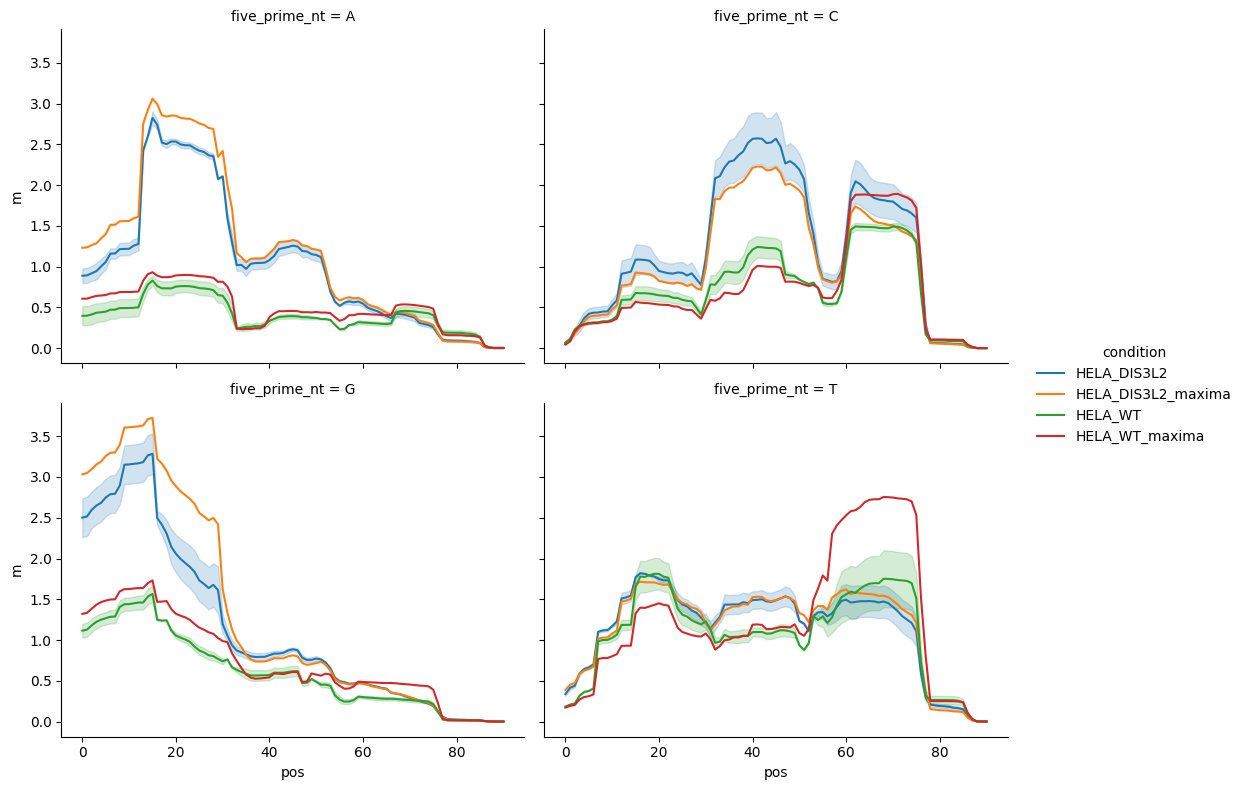

In [53]:
res_merge = res.merge(conditions, how = 'left', left_on = 'alias', right_on = 'simple_name')
res_grouped = res_merge.groupby(['pos', 'condition', 'five_prime_nt']).agg(count = ('count', 'mean'), S = ('count', 'std')).reset_index()
res_grouped['group'] = ''

plot_metagene(res_grouped,
              shade = 'S', 
              x_col = 'pos', 
              y_col = 'count', 
              facet_by = 'five_prime_nt',
              plot_group = 'condition'
             )